# Chapter 2: Beyond the Arrow - The Wedge Product

**Geometric Algebra for Data Science, Part 1**

**Article scheduled for**: January 14, 2026

---

## The Problem

In Chapter 1, we learned that data should be treated as geometric objects with orthogonal basis vectors:

$$\mathbf{x} = v_1\mathbf{e}_1 + v_2\mathbf{e}_2 + v_3\mathbf{e}_3$$

But how do we measure the **independence** between two vectors?

- **Dot Product** ($\mathbf{u} \cdot \mathbf{v}$): Good for similarity, but destroys information about independence
- **Cross Product** ($\mathbf{u} \times \mathbf{v}$): Only works in 3D (and 7D)

We need something better: **The Wedge Product** ($\mathbf{u} \wedge \mathbf{v}$)

---

## Setup

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from chapter_2_wedge_product import (
    wedge_product_tensor,
    wedge_magnitude,
    are_vectors_independent,
    independence_strength,
    extract_basis_planes,
    BatchWedgeProduct,
    get_device
)

# Check GPU availability
device = get_device()
print(f"\nPyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

Using GPU: NVIDIA GB10

PyTorch version: 2.9.1+cu129
CUDA available: True


/home/asudjianto/jupyterlab/ga_verify/venv/lib/python3.12/site-packages/torch/cuda/__init__.py:283: UserWarning: 
    Found GPU0 NVIDIA GB10 which is of cuda capability 12.1.
    Minimum and Maximum cuda capability supported by this version of PyTorch is
    (8.0) - (12.0)
    
  warnings.warn(


---
## Part 1: The Flaw in the Cross Product

### Why the Cross Product is a "Hack"

The cross product has two major problems:
1. **Only works in 3D** (and technically 7D)
2. **Returns a vector** - Why does the area of a floor (XY plane) point "up" (Z-axis)?

Let's see this in action:

In [2]:
print("=" * 70)
print("CROSS PRODUCT: Works in 3D")
print("=" * 70)

# Two vectors in 3D
u_3d = torch.tensor([1.0, 0.0, 0.0])  # X-axis
v_3d = torch.tensor([0.0, 1.0, 0.0])  # Y-axis

print(f"\nVector u: {u_3d}")
print(f"Vector v: {v_3d}")

# Cross product
cross = torch.linalg.cross(u_3d, v_3d)
print(f"\nu × v (cross product): {cross}")
print(f"Magnitude: {torch.norm(cross):.4f}")
print(f"\nProblem: Result points in Z direction [0, 0, 1]")
print("Why? The XY plane area shouldn't have a Z component!")

CROSS PRODUCT: Works in 3D

Vector u: tensor([1., 0., 0.])
Vector v: tensor([0., 1., 0.])

u × v (cross product): tensor([0., 0., 1.])
Magnitude: 1.0000

Problem: Result points in Z direction [0, 0, 1]
Why? The XY plane area shouldn't have a Z component!


In [3]:
print("\n" + "=" * 70)
print("CROSS PRODUCT: FAILS in 4D")
print("=" * 70)

# Try in 4D
u_4d = torch.randn(4)
v_4d = torch.randn(4)

print(f"\nVector u (4D): {u_4d}")
print(f"Vector v (4D): {v_4d}")

print("\nAttempting cross product...")
try:
    cross_4d = torch.linalg.cross(u_4d, v_4d)
    print(f"Result: {cross_4d}")
except RuntimeError as e:
    print(f"ERROR: {e}")
    print("\nCross product doesn't exist in 4D!")
    print("This is a problem for data science with many features.")


CROSS PRODUCT: FAILS in 4D

Vector u (4D): tensor([-1.8078, -0.7557, -0.6983,  0.7506])
Vector v (4D): tensor([ 0.4098, -1.2586, -0.5673, -0.2494])

Attempting cross product...
ERROR: linalg.cross: inputs dimension -1 must have length 3. Got 4 and 4

Cross product doesn't exist in 4D!
This is a problem for data science with many features.


---
## Part 2: Enter the Wedge Product (∧)

The **Wedge Product** is the solution. It:
- Works in **any dimension**
- Returns a **bivector** (a 2D geometric object, not a 1D vector)
- Represents the **oriented area** spanned by two vectors

### Mathematical Definition

$$\mathbf{u} \wedge \mathbf{v} = \mathbf{u} \otimes \mathbf{v} - \mathbf{v} \otimes \mathbf{u}$$

where $\otimes$ is the outer product (antisymmetric part).

### Properties

1. **Antisymmetric**: $\mathbf{u} \wedge \mathbf{v} = -(\mathbf{v} \wedge \mathbf{u})$
2. **Magnitude**: Area of parallelogram
3. **Zero if parallel**: $\mathbf{u} \wedge \mathbf{v} = 0$ means linearly dependent

In [4]:
print("=" * 70)
print("WEDGE PRODUCT: The Solution")
print("=" * 70)

# Same vectors as before
u_3d = torch.tensor([1.0, 0.0, 0.0])  # X-axis
v_3d = torch.tensor([0.0, 1.0, 0.0])  # Y-axis

print(f"\nVector u: {u_3d}")
print(f"Vector v: {v_3d}")

# Wedge product
B = wedge_product_tensor(u_3d, v_3d)
print(f"\nu ∧ v (wedge product):\n{B}")

print("\nInterpretation:")
print(f"  B[0,1] = {B[0,1]:.1f}  -> XY plane area")
print(f"  B[1,0] = {B[1,0]:.1f}  -> Antisymmetry (YX = -XY)")
print(f"  B[0,2] = {B[0,2]:.1f}  -> No XZ plane area")
print(f"  B[1,2] = {B[1,2]:.1f}  -> No YZ plane area")

area = wedge_magnitude(B)
print(f"\nArea of parallelogram: {area:.4f}")

WEDGE PRODUCT: The Solution

Vector u: tensor([1., 0., 0.])
Vector v: tensor([0., 1., 0.])

u ∧ v (wedge product):
tensor([[ 0.,  1.,  0.],
        [-1.,  0.,  0.],
        [ 0.,  0.,  0.]])

Interpretation:
  B[0,1] = 1.0  -> XY plane area
  B[1,0] = -1.0  -> Antisymmetry (YX = -XY)
  B[0,2] = 0.0  -> No XZ plane area
  B[1,2] = 0.0  -> No YZ plane area

Area of parallelogram: 1.0000


### Visualizing the Bivector

The wedge product creates a **bivector** - a 2D oriented plane in N-dimensional space.

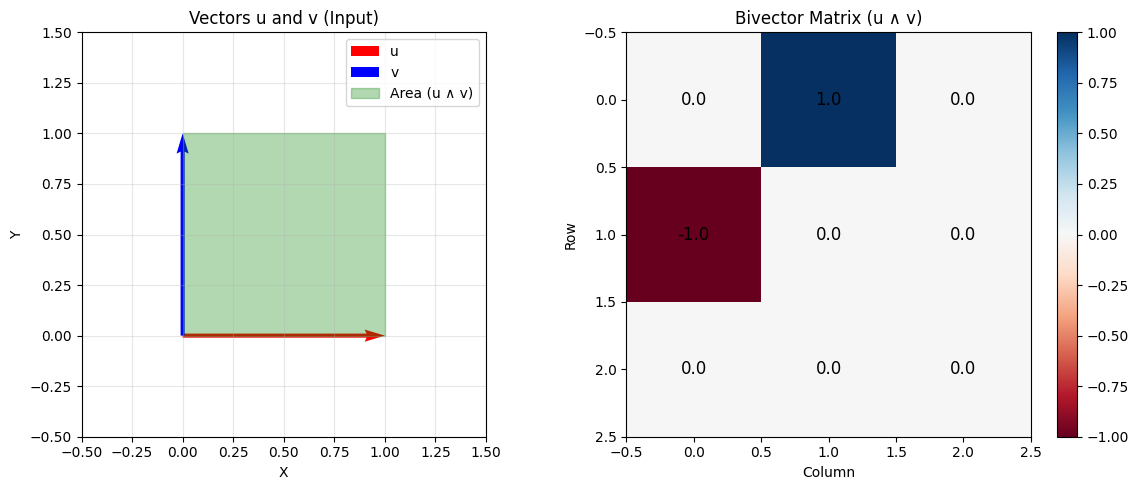

The bivector matrix encodes the oriented area in the XY plane!


In [5]:
# Visualize the bivector matrix
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: The vectors
ax = axes[0]
ax.quiver(0, 0, 1, 0, angles='xy', scale_units='xy', scale=1, color='red', width=0.01, label='u')
ax.quiver(0, 0, 0, 1, angles='xy', scale_units='xy', scale=1, color='blue', width=0.01, label='v')
ax.fill([0, 1, 1, 0], [0, 0, 1, 1], alpha=0.3, color='green', label='Area (u ∧ v)')
ax.set_xlim(-0.5, 1.5)
ax.set_ylim(-0.5, 1.5)
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)
ax.legend()
ax.set_title('Vectors u and v (Input)')
ax.set_xlabel('X')
ax.set_ylabel('Y')

# Plot 2: The bivector matrix
ax = axes[1]
B_np = B.numpy()
im = ax.imshow(B_np, cmap='RdBu', vmin=-1, vmax=1)
ax.set_title('Bivector Matrix (u ∧ v)')
ax.set_xlabel('Column')
ax.set_ylabel('Row')
plt.colorbar(im, ax=ax)

# Add values as text
for i in range(3):
    for j in range(3):
        text = ax.text(j, i, f'{B_np[i, j]:.1f}',
                      ha="center", va="center", color="black", fontsize=12)

plt.tight_layout()
plt.show()

print("The bivector matrix encodes the oriented area in the XY plane!")

---
## Part 3: The 4D Advantage

Unlike the cross product, the wedge product works perfectly in **any dimension**.

In [6]:
print("=" * 70)
print("WEDGE PRODUCT: Works in 4D (and any dimension!)")
print("=" * 70)

# Create 4D vectors (e.g., [height, weight, age, income])
u_4d = torch.tensor([1.7, 75.0, 30.0, 50000.0])
v_4d = torch.tensor([1.6, 60.0, 25.0, 45000.0])

# Normalize for better interpretation
u_4d = u_4d / torch.norm(u_4d)
v_4d = v_4d / torch.norm(v_4d)

print(f"\nVector u (4D): {u_4d}")
print(f"Vector v (4D): {v_4d}")

# Wedge product
B_4d = wedge_product_tensor(u_4d, v_4d)
print(f"\nBivector shape: {B_4d.shape}")
print(f"Area magnitude: {wedge_magnitude(B_4d):.4f}")

# Extract basis plane projections
planes = extract_basis_planes(B_4d)
print(f"\nNumber of basis planes in 4D: {len(planes)}")
print("(Formula: N(N-1)/2 = 4(3)/2 = 6 planes)\n")

print("Projected areas on each basis plane:")
for plane, coef in planes.items():
    print(f"  {plane}: {coef:.4f}")

WEDGE PRODUCT: Works in 4D (and any dimension!)

Vector u (4D): tensor([3.4000e-05, 1.5000e-03, 6.0000e-04, 1.0000e+00])
Vector v (4D): tensor([3.5556e-05, 1.3333e-03, 5.5555e-04, 1.0000e+00])

Bivector shape: torch.Size([4, 4])
Area magnitude: 0.0002

Number of basis planes in 4D: 6
(Formula: N(N-1)/2 = 4(3)/2 = 6 planes)

Projected areas on each basis plane:
  e0∧e1: -0.0000
  e0∧e2: -0.0000
  e0∧e3: -0.0000
  e1∧e2: 0.0000
  e1∧e3: 0.0002
  e2∧e3: 0.0000


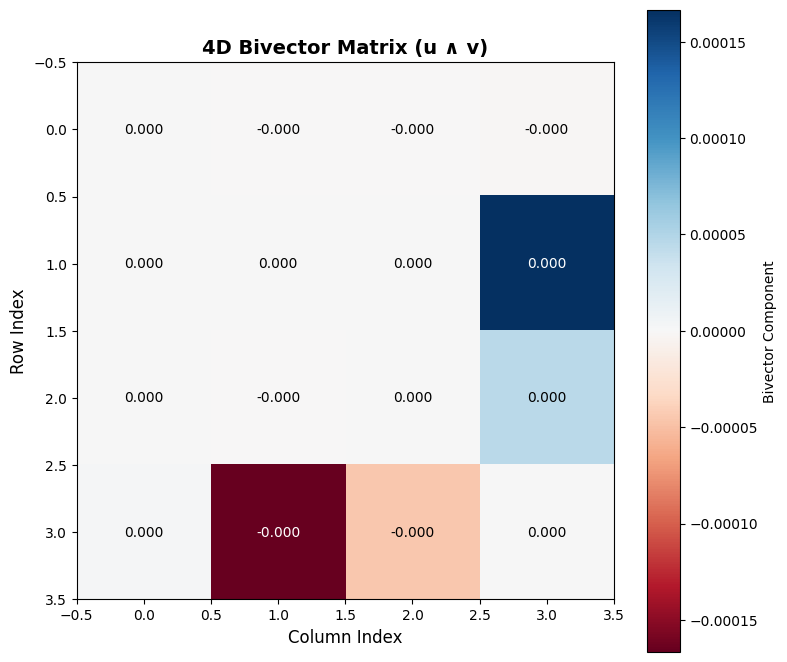


Notice the antisymmetry: B[i,j] = -B[j,i]
This encodes 6 independent plane areas in 4D space!


In [7]:
# Visualize the 4D bivector matrix
fig, ax = plt.subplots(figsize=(8, 7))

B_4d_np = B_4d.numpy()
im = ax.imshow(B_4d_np, cmap='RdBu', vmin=-B_4d_np.max(), vmax=B_4d_np.max())
ax.set_title('4D Bivector Matrix (u ∧ v)', fontsize=14, fontweight='bold')
ax.set_xlabel('Column Index', fontsize=12)
ax.set_ylabel('Row Index', fontsize=12)

# Add values as text
for i in range(4):
    for j in range(4):
        text = ax.text(j, i, f'{B_4d_np[i, j]:.3f}',
                      ha="center", va="center", 
                      color="white" if abs(B_4d_np[i, j]) > 0.5 * B_4d_np.max() else "black",
                      fontsize=10)

plt.colorbar(im, ax=ax, label='Bivector Component')
plt.tight_layout()
plt.show()

print("\nNotice the antisymmetry: B[i,j] = -B[j,i]")
print("This encodes 6 independent plane areas in 4D space!")

---
## Part 4: Measuring Linear Independence

The wedge product is perfect for detecting **linear independence**:

- If $\mathbf{u} \wedge \mathbf{v} = 0$: Vectors are **linearly dependent** (collinear)
- If $||\mathbf{u} \wedge \mathbf{v}|| = ||\mathbf{u}|| \cdot ||\mathbf{v}||$: Vectors are **orthogonal** (maximally independent)

### Independence Strength

We define independence strength as:

$$\text{independence} = \frac{||\mathbf{u} \wedge \mathbf{v}||}{||\mathbf{u}|| \cdot ||\mathbf{v}||} \in [0, 1]$$

In [8]:
print("=" * 70)
print("LINEAR INDEPENDENCE TESTING")
print("=" * 70)

# Case 1: Orthogonal vectors (maximally independent)
print("\n1. ORTHOGONAL VECTORS (Maximally Independent)")
print("-" * 70)
u1 = torch.tensor([1.0, 0.0, 0.0])
v1 = torch.tensor([0.0, 1.0, 0.0])
indep1 = independence_strength(u1, v1)
print(f"u: {u1}")
print(f"v: {v1}")
print(f"Independence: {indep1:.4f}")
print(f"→ {indep1:.1f} = Perfectly orthogonal")

# Case 2: Parallel vectors (dependent)
print("\n2. PARALLEL VECTORS (Linearly Dependent)")
print("-" * 70)
u2 = torch.tensor([1.0, 2.0, 3.0])
v2 = 2.0 * u2  # Exact multiple
indep2 = independence_strength(u2, v2)
print(f"u: {u2}")
print(f"v: {v2}")
print(f"Independence: {indep2:.6f}")
print(f"→ ~0 = Collinear (dependent)")

# Case 3: Partially dependent
print("\n3. PARTIALLY DEPENDENT VECTORS")
print("-" * 70)
u3 = torch.tensor([1.0, 0.0, 0.0])
v3 = torch.tensor([0.8, 0.6, 0.0])
indep3 = independence_strength(u3, v3)
angle = torch.acos(torch.dot(u3, v3) / (torch.norm(u3) * torch.norm(v3)))
print(f"u: {u3}")
print(f"v: {v3}")
print(f"Angle: {np.degrees(angle.item()):.1f}°")
print(f"Independence: {indep3:.4f}")
print(f"→ {indep3:.2f} = Partially independent")

LINEAR INDEPENDENCE TESTING

1. ORTHOGONAL VECTORS (Maximally Independent)
----------------------------------------------------------------------
u: tensor([1., 0., 0.])
v: tensor([0., 1., 0.])
Independence: 1.0000
→ 1.0 = Perfectly orthogonal

2. PARALLEL VECTORS (Linearly Dependent)
----------------------------------------------------------------------
u: tensor([1., 2., 3.])
v: tensor([2., 4., 6.])
Independence: 0.000000
→ ~0 = Collinear (dependent)

3. PARTIALLY DEPENDENT VECTORS
----------------------------------------------------------------------
u: tensor([1., 0., 0.])
v: tensor([0.8000, 0.6000, 0.0000])
Angle: 36.9°
Independence: 0.6000
→ 0.60 = Partially independent


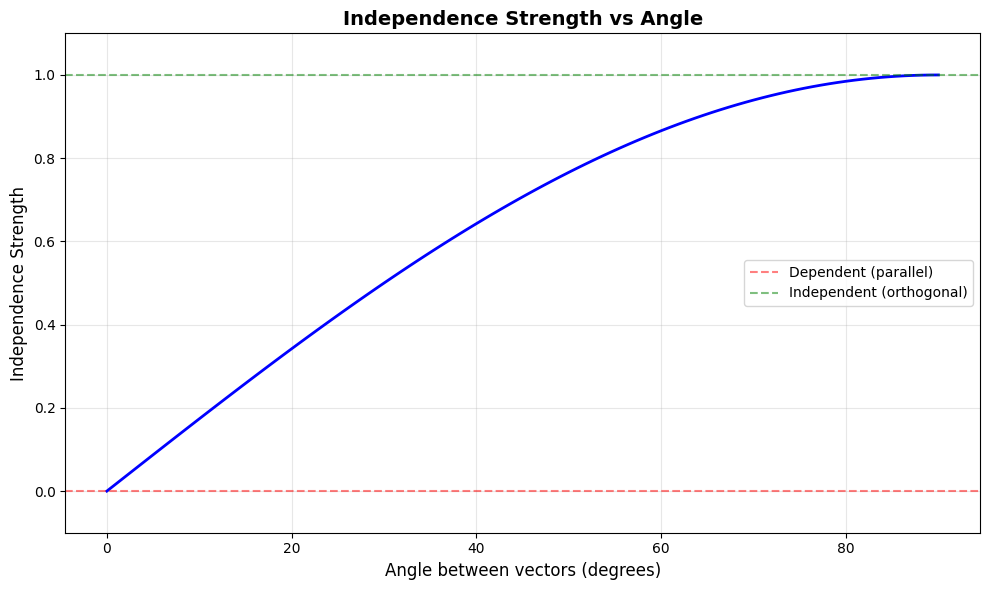


Key insight: Independence = sin(angle)
  0° (parallel) → independence = 0
 90° (orthogonal) → independence = 1


In [9]:
# Visualize independence vs angle
angles = np.linspace(0, 90, 100)
independence_vals = []

u = torch.tensor([1.0, 0.0, 0.0])
for angle_deg in angles:
    angle_rad = np.radians(angle_deg)
    v = torch.tensor([np.cos(angle_rad), np.sin(angle_rad), 0.0])
    indep = independence_strength(u, v)
    independence_vals.append(indep)

plt.figure(figsize=(10, 6))
plt.plot(angles, independence_vals, linewidth=2, color='blue')
plt.axhline(y=0, color='red', linestyle='--', alpha=0.5, label='Dependent (parallel)')
plt.axhline(y=1, color='green', linestyle='--', alpha=0.5, label='Independent (orthogonal)')
plt.xlabel('Angle between vectors (degrees)', fontsize=12)
plt.ylabel('Independence Strength', fontsize=12)
plt.title('Independence Strength vs Angle', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)
plt.ylim(-0.1, 1.1)
plt.tight_layout()
plt.show()

print("\nKey insight: Independence = sin(angle)")
print("  0° (parallel) → independence = 0")
print(" 90° (orthogonal) → independence = 1")

---
## Part 5: Application - Detecting Multicollinearity

One of the most practical applications: **detecting multicollinearity in features**.

If two features are highly correlated (low independence), they provide redundant information.

In [10]:
print("=" * 70)
print("APPLICATION: Detecting Multicollinearity in Housing Features")
print("=" * 70)

# Simulate housing features (normalized)
sqft_feature = torch.tensor([2500, 3, 2, 20], dtype=torch.float32)
sqft_feature = sqft_feature / torch.norm(sqft_feature)

# Bedroom feature (highly correlated with sqft)
bedroom_feature = torch.tensor([2400, 3.2, 2.1, 18], dtype=torch.float32)
bedroom_feature = bedroom_feature / torch.norm(bedroom_feature)

# Age feature (independent from sqft)
age_feature = torch.tensor([1800, 2, 1, 50], dtype=torch.float32)
age_feature = age_feature / torch.norm(age_feature)

# Measure independence
indep_sqft_bedroom = independence_strength(sqft_feature, bedroom_feature)
indep_sqft_age = independence_strength(sqft_feature, age_feature)

print(f"\nIndependence Analysis:")
print(f"  sqft ∧ bedrooms = {indep_sqft_bedroom:.4f}")
print(f"  sqft ∧ age = {indep_sqft_age:.4f}")

print(f"\nInterpretation:")
if indep_sqft_bedroom < 0.3:
    print(f"  ⚠️  sqft and bedrooms are highly correlated!")
    print(f"      This is multicollinearity - consider removing one feature.")
if indep_sqft_age > 0.5:
    print(f"  ✓  sqft and age are relatively independent.")
    print(f"      Both features provide unique information.")

APPLICATION: Detecting Multicollinearity in Housing Features

Independence Analysis:
  sqft ∧ bedrooms = 0.0005
  sqft ∧ age = 0.0198

Interpretation:
  ⚠️  sqft and bedrooms are highly correlated!
      This is multicollinearity - consider removing one feature.


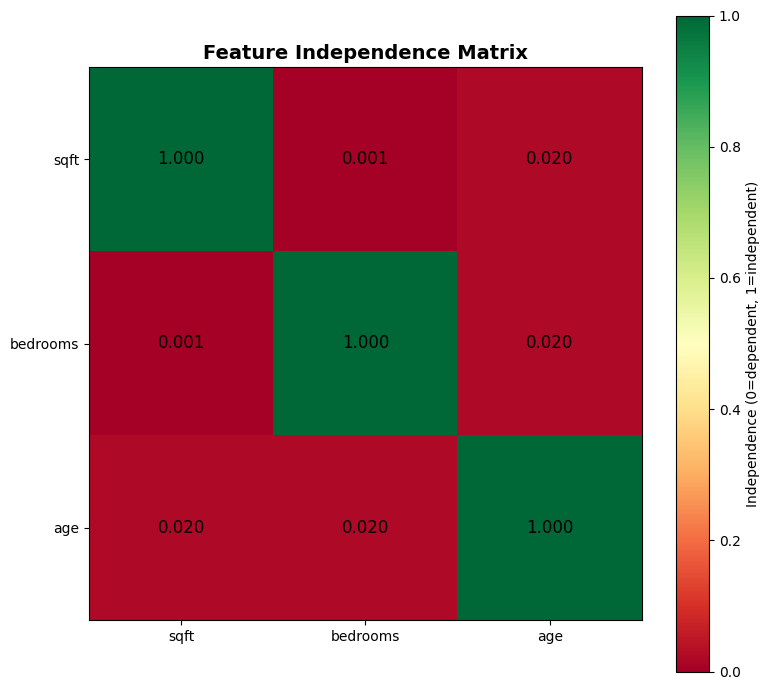


Green = Independent (good!)
Red = Dependent (multicollinearity warning!)


In [11]:
# Visualize feature independence matrix
features = {
    'sqft': sqft_feature,
    'bedrooms': bedroom_feature,
    'age': age_feature
}

feature_names = list(features.keys())
n_features = len(feature_names)

# Compute pairwise independence
independence_matrix = torch.zeros(n_features, n_features)
for i, name1 in enumerate(feature_names):
    for j, name2 in enumerate(feature_names):
        if i == j:
            independence_matrix[i, j] = 1.0  # Self-independence
        else:
            independence_matrix[i, j] = independence_strength(features[name1], features[name2])

# Plot
fig, ax = plt.subplots(figsize=(8, 7))
im = ax.imshow(independence_matrix.numpy(), cmap='RdYlGn', vmin=0, vmax=1)
ax.set_xticks(range(n_features))
ax.set_yticks(range(n_features))
ax.set_xticklabels(feature_names)
ax.set_yticklabels(feature_names)
ax.set_title('Feature Independence Matrix', fontsize=14, fontweight='bold')

# Add values
for i in range(n_features):
    for j in range(n_features):
        text = ax.text(j, i, f'{independence_matrix[i, j]:.3f}',
                      ha="center", va="center", color="black", fontsize=12)

plt.colorbar(im, ax=ax, label='Independence (0=dependent, 1=independent)')
plt.tight_layout()
plt.show()

print("\nGreen = Independent (good!)")
print("Red = Dependent (multicollinearity warning!)")

---
## Part 6: GPU-Accelerated Batch Processing

For real-world datasets, we need to process thousands of vector pairs efficiently.

In [12]:
print("=" * 70)
print("GPU-ACCELERATED BATCH PROCESSING")
print("=" * 70)

# Create batch processor
batch_processor = BatchWedgeProduct()

# Generate random feature pairs
batch_size = 5000
dim = 20

print(f"\nProcessing {batch_size} pairs of {dim}-dimensional vectors...")

u_batch = torch.randn(batch_size, dim)
v_batch = torch.randn(batch_size, dim)

# Compute batch statistics
import time
start = time.time()
independence = batch_processor.batch_independence(u_batch, v_batch)
elapsed = time.time() - start

print(f"\nTime taken: {elapsed:.4f} seconds")
print(f"Throughput: {batch_size/elapsed:.0f} pairs/second")

print(f"\nIndependence Statistics:")
print(f"  Mean: {independence.mean():.4f}")
print(f"  Std: {independence.std():.4f}")
print(f"  Min: {independence.min():.4f}")
print(f"  Max: {independence.max():.4f}")

GPU-ACCELERATED BATCH PROCESSING
Using GPU: NVIDIA GB10

Processing 5000 pairs of 20-dimensional vectors...

Time taken: 0.3681 seconds
Throughput: 13585 pairs/second

Independence Statistics:
  Mean: 0.9743
  Std: 0.0349
  Min: 0.7031
  Max: 1.0000


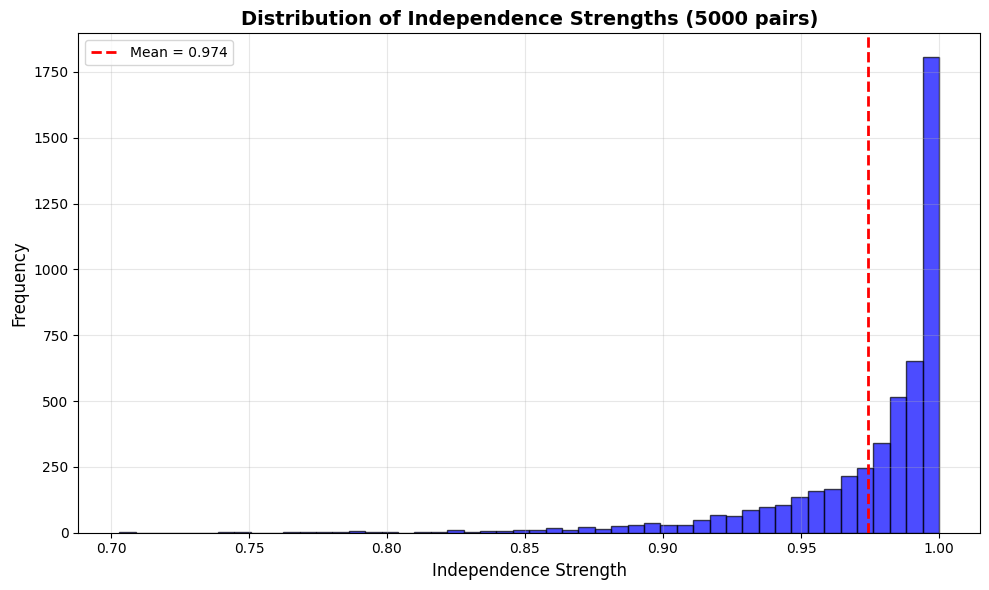


For random vectors, independence clusters around ~0.95
(Most random vectors are nearly orthogonal in high dimensions)


In [13]:
# Visualize distribution
plt.figure(figsize=(10, 6))
plt.hist(independence.cpu().numpy(), bins=50, alpha=0.7, color='blue', edgecolor='black')
plt.axvline(independence.mean().item(), color='red', linestyle='--', 
           linewidth=2, label=f'Mean = {independence.mean():.3f}')
plt.xlabel('Independence Strength', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title(f'Distribution of Independence Strengths ({batch_size} pairs)', 
         fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nFor random vectors, independence clusters around ~0.95")
print("(Most random vectors are nearly orthogonal in high dimensions)")

---
## Part 7: High-Dimensional Embeddings

The wedge product shines in **high-dimensional spaces** like NLP embeddings.

In [14]:
print("=" * 70)
print("HIGH-DIMENSIONAL EMBEDDINGS (100D)")
print("=" * 70)

# Simulate word embeddings
dim_embedding = 100

word1 = torch.randn(dim_embedding)
word2 = torch.randn(dim_embedding)
word3 = word1 + 0.1 * torch.randn(dim_embedding)  # Similar to word1

# Normalize
word1 = word1 / torch.norm(word1)
word2 = word2 / torch.norm(word2)
word3 = word3 / torch.norm(word3)

# Measure independence
indep_12 = independence_strength(word1, word2)
indep_13 = independence_strength(word1, word3)
indep_23 = independence_strength(word2, word3)

print(f"\nEmbedding Dimension: {dim_embedding}D")
print(f"\nIndependence Measurements:")
print(f"  word1 ∧ word2: {indep_12:.4f}")
print(f"  word1 ∧ word3: {indep_13:.4f}")
print(f"  word2 ∧ word3: {indep_23:.4f}")

print(f"\nInterpretation:")
if indep_13 < 0.5:
    print(f"  word1 and word3 are RELATED (low independence = {indep_13:.3f})")
if indep_12 > 0.9:
    print(f"  word1 and word2 are INDEPENDENT (high independence = {indep_12:.3f})")

# Compute areas
B_12 = wedge_product_tensor(word1, word2)
B_13 = wedge_product_tensor(word1, word3)

area_12 = wedge_magnitude(B_12)
area_13 = wedge_magnitude(B_13)

print(f"\nArea Analysis:")
print(f"  Area(word1, word2): {area_12:.4f}")
print(f"  Area(word1, word3): {area_13:.4f}")
print(f"\nLarger area = more independent")

HIGH-DIMENSIONAL EMBEDDINGS (100D)

Embedding Dimension: 100D

Independence Measurements:
  word1 ∧ word2: 0.9990
  word1 ∧ word3: 0.0891
  word2 ∧ word3: 0.9988

Interpretation:
  word1 and word3 are RELATED (low independence = 0.089)
  word1 and word2 are INDEPENDENT (high independence = 0.999)

Area Analysis:
  Area(word1, word2): 0.9990
  Area(word1, word3): 0.0891

Larger area = more independent


---
## Summary: Why the Wedge Product Matters

### Key Takeaways

1. **Works in ANY Dimension**
   - Cross product: Only 3D (and 7D)
   - Wedge product: 2D, 3D, 4D, 100D, 1000D - any dimension!

2. **Measures Linear Independence**
   - If $||\mathbf{u} \wedge \mathbf{v}|| = 0$: Vectors are linearly dependent
   - Normalized magnitude gives independence strength [0, 1]

3. **Retains Geometric Information**
   - Dot product → scalar (information loss)
   - Wedge product → bivector (full geometric relationship preserved)

4. **GPU Accelerated**
   - Batch processing on GPU
   - Thousands of pairs per second
   - Practical for large datasets

5. **Practical Applications**
   - Multicollinearity detection
   - Feature selection
   - Embedding analysis
   - Dimensionality reduction
   - Independence testing

### The Cliffhanger

We now have:
- **Dot Product** ($\mathbf{u} \cdot \mathbf{v}$): Measures similarity
- **Wedge Product** ($\mathbf{u} \wedge \mathbf{v}$): Measures independence

But what if we could **combine** them?

**Next: Chapter 3 - The Geometric Product** (The Master Algorithm)

$$\mathbf{uv} = \mathbf{u} \cdot \mathbf{v} + \mathbf{u} \wedge \mathbf{v}$$

This unified operator will allow us to **divide by vectors** and perform algebraic manipulation of geometric objects!

---

## Exercises

Try these to deepen your understanding:

1. Compute the wedge product of three orthogonal basis vectors in 5D
2. Find two vectors with independence strength exactly 0.5
3. Create a function to detect the most collinear pair in a batch
4. Visualize how independence changes as you rotate one vector around another
5. Apply wedge products to real dataset features and find multicollinearity

In [ ]:
# Your experiments here!
